# Home Work 1


## Description.

Apply your knowledge about Fully-Connected NNs so far to solve several classification tasks


## Evaluation.

Along with every graded task you will see the maximum grading possible for it placed in (parenthesis). Grade might be lowered. The clear indicator that you won't get a maximum amount of points for a task is that your code does not work and/or your NN is not training. In order to obtain the maximum points you have to have sufficient accuracy >90%


### Good luck!

In [ ]:
import numpy as np
import copy
import torch
from torch import nn
import torch.optim as optim
import tqdm
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Data

This is a toy dataset. <br>
$x \in \mathbb{R}^2, y \in \{0, 1\}$

In [ ]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

#### **Выделяем train, test и valid для дальнейшей работы:**

In [ ]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.30, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


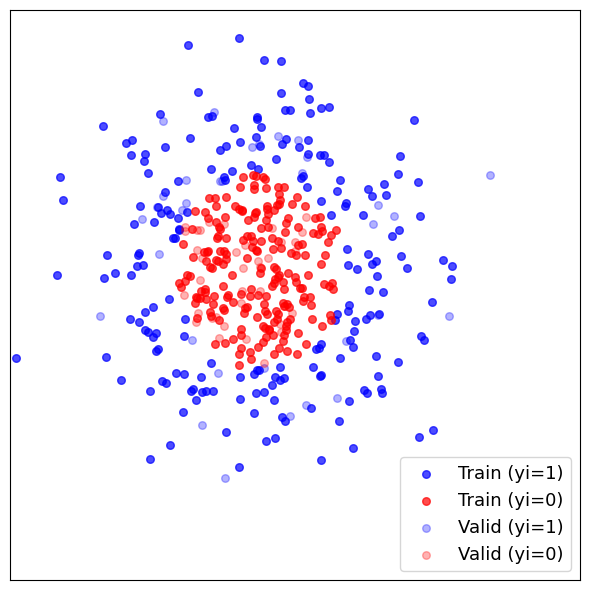

In [ ]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

# NN declaration (1 points)

You need to implement a class for a simple FC NN. Add as many layers and as many neurons as you'd like.

#### **FC NN состоит из трех линейных слоев, к которым применены фукнции активации LeakyReLU и сигмоида. Так как классификация бинарная, то на выходе будет 1 нейрон:**

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 120)
        self.act1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(120, 60)
        self.act2 = nn.LeakyReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x.reshape(-1)

#  Train function. (1.5 points)
Add missing parts

In [ ]:
def train(model, loss_fn, opt,
          n_epochs, batch_size,
          X_train, y_train, X_val=None, y_val=None):

    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)
    x_val_ld = DataLoader(X_val, batch_size=1) if X_val is not None else None
    y_val_ld = DataLoader(y_val, batch_size=1) if y_val is not None else None
    batch_start = torch.arange(0, len(X_train), batch_size)
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    preds_history = []
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x, y in zip(x_train_loader, y_train_loader):
                #forward
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                # backward pass
                opt.zero_grad()
                loss.backward()
                # update weights
                opt.step()
                # print progress
                bar.set_postfix(mse=float(loss))
                # print progress
                acc = (y_pred.round() == y).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        preds_history.append(loss.item())
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)

        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.98:
            break

    # restore model and return best accuracy
    model.load_state_dict(best_weights)

    return best_acc, model, preds_history

# Train the network. (1 point)

Train NN three times: with three different optimization algorithms. Don't forget to reinitialize model before each train. Make sure you pass the correct arguments to opt.

**Hint** It is better to have three different objects - model1, model2, and model3

####**Здесь происходит обучение моделей с использованием различных оптимизаторов и функции потерь для бинарной классификации. Для того, чтобы лосс понижался, я подобрала соответствующие значения learning rate и также batch_size, который влиял почти только на обучение с SGD.**

In [ ]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_valid).float()
y_valid_torch = torch.from_numpy(y_valid).float()

model = NeuralNetwork()
loss = nn.BCELoss()

print('SGD:\n')
optim1 = optim.SGD(model.parameters(), lr=5e-2)
acc1, model1, preds_history_1 = train(model, loss, optim1, 50, 64, X_train_torch, y_train_torch, X_valid_torch, y_valid_torch)

print('\nAdam:\n')
model = NeuralNetwork()
optim2 = optim.Adam(model.parameters(), lr=1e-3)
acc2, model2, preds_history_2 = train(model, loss, optim2, 50, 32, X_train_torch, y_train_torch, X_valid_torch, y_valid_torch)

print('\nRMSprop:\n')
model = NeuralNetwork()
optim3 = optim.RMSprop(model.parameters(), lr=1e-2)
acc3, model3, preds_history_3 = train(model, loss, optim3, 50, 32, X_train_torch, y_train_torch, X_valid_torch, y_valid_torch)


SGD:



Epoch 49:   0%|          | 0/7 [00:00<?, ?batch/s, acc=1, loss=0.113]



Adam:



Epoch 8:   0%|          | 0/13 [00:00<?, ?batch/s, acc=1, loss=0.106]



RMSprop:



Epoch 7:   0%|          | 0/13 [00:00<?, ?batch/s, acc=1, loss=0.0549]


In [ ]:
print(acc1, acc2, acc3)

0.9666666388511658 1.0 1.0


#### **Каждый раз обучается немного странно (останавливается на разном количетсве эпох, что влияет на значение последнего лосса, и очень сильно зависит от learning rate, ), но всегда Adam и RMSProp обучаются быстрее SGD. Обычно у меня получилось так, что начальный лосс у Adam больше чем у RMSProp, при этом обычно лосс быстрее всех падает у Adam (но это всё, конечно же, зависит от подобранных параметров. Можно долго играться с их подбором, но решила оставить так).**

### А теперь посмотрим на графики лоссов

#### **Начальный лосс так же колеблется в зависимости от подобранных параметров**

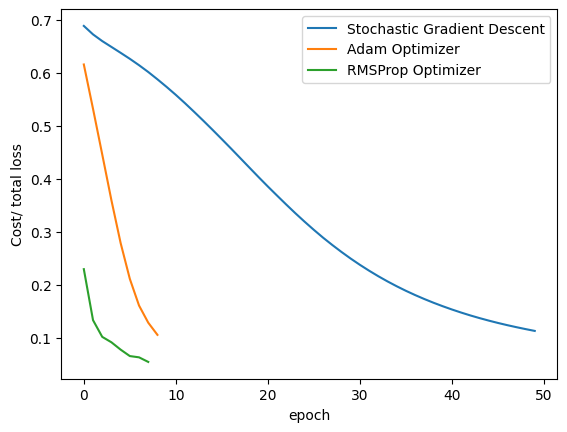

In [ ]:
plt.plot(preds_history_1, label = "Stochastic Gradient Descent")
plt.plot(preds_history_2, label = "Adam Optimizer")
plt.plot(preds_history_3, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

#### **Проверим на тестовой выборке X_test и y_test используя наши обученные model1, model2 и model3:**

In [ ]:
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()

y_pred_SGD = model1(X_test_torch) # SGD
y_pred_Adam = model2(X_test_torch) # Adam
y_pred_PROP = model3(X_test_torch) # RMSProp

In [ ]:
# SGD check:
best_acc_SGD = 0
acc_SGD = (y_pred_SGD.round() == y_test_torch).float().mean()
acc_SGD = float(acc_SGD)
if acc_SGD > best_acc_SGD:
      best_acc_SGD = acc_SGD


# Adam check:
best_acc_Adam = 0
acc_Adam = (y_pred_Adam.round() == y_test_torch).float().mean()
acc_Adam = float(acc_Adam)
if acc_Adam > best_acc_Adam:
      best_acc_Adam = acc_Adam


# RMSProp check:
best_acc_PROP = 0
acc_PROP = (y_pred_PROP.round() == y_test_torch).float().mean()
acc_PROP = float(acc_PROP)
if acc_PROP > best_acc_PROP:
      best_acc_PROP = acc_PROP

In [ ]:
print(best_acc_SGD, best_acc_Adam, best_acc_PROP)

0.9428571462631226 0.9714285731315613 0.9428571462631226


#### **Лучший результат у Adam!**

___

# Now solve multi-class task (2.5 points)

You are welcome to use anything you know.


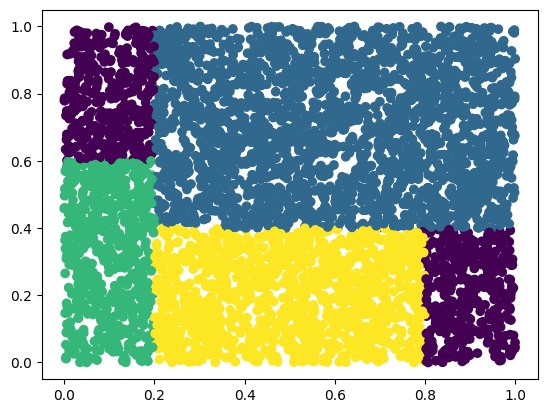

In [ ]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

#### **Slice data (делим треноровочную, тестовую и валидационную выборки на Х и у, при этом пропускаем таргетные через OHE, чтобы значения лежали в диапазоне от 0 до 1):**

In [ ]:
import torch.nn.functional as F

In [ ]:
idx1 = torch.LongTensor([0, 1])
idx2 = torch.LongTensor([2])

x_train_multi = train[:, idx1]
y_train_multi = train[:, idx2]
x_test_multi = test[:, idx1]
y_test_multi = test[:, idx2]
x_valid_multi = valid[:, idx1]
y_valid_multi = valid[:, idx2]

y_train_ohe = np.reshape(F.one_hot(y_train_multi.to(torch.int64), num_classes=4), (800,4))
y_test_ohe = np.reshape(F.one_hot(y_test_multi.to(torch.int64), num_classes=4),(4100,4))
y_valid_ohe = np.reshape(F.one_hot(y_valid_multi.to(torch.int64), num_classes=4),(100,4))

#### **AdvancedModel (я взяла предыдущую NN и просто добавила два слоя BatchNorm, потому что с ними всё обучилось. Пробовала использовать Dropout, но, как мне показалось, он никак не помог. Кроме того, немного увеличила количество нейронов). В данном случае количество выходных нейронов равно n_classes, так как многоклассовая класификация. Также вместо сигмоиды в конце используется softmax, чтобы не просто получать вероятности, но и получать из них сумму 1:**

In [ ]:
class AdvancedModel(nn.Module):
    def __init__(self, n_classes):
        super(AdvancedModel, self).__init__()
        self.layer1 = nn.Linear(2, 240)
        self.batch_norm1 = nn.BatchNorm1d(240)
        self.act1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(240, 120)
        self.batch_norm2 = nn.BatchNorm1d(120)
        self.act2 = nn.LeakyReLU()
        self.output = nn.Linear(120, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.batch_norm1(self.layer1(x)))
        x = self.act2(self.batch_norm2(self.layer2(x)))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
def train_model_advanced(model, loss_fn, opt,
          n_epochs, batch_size,
          X_train, y_train, X_val=None, y_val=None):

    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)
    x_val_ld = DataLoader(X_val, batch_size=1) if X_val is not None else None
    y_val_ld = DataLoader(y_val, batch_size=1) if y_val is not None else None
    batch_start = torch.arange(0, len(X_train), batch_size)
    # Hold the best model
    best_acc = - np.inf
    best_weights = None
    preds_history = []
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x, y in zip(x_train_loader, y_train_loader):
                #forward
                y_pred = model(x)
                loss = loss_fn(y_pred, y.float())
                # backward pass
                opt.zero_grad()
                loss.backward()
                # update weights
                opt.step()
                # print progress
                bar.set_postfix(mse=float(loss))
                # print progress
                acc = (y_pred.round() == y).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        preds_history.append(loss.item())
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.98:
            break

    # restore model and return best accuracy
    model.load_state_dict(best_weights)

    return best_acc, model, y_pred

#### **Для обучения использовался оптимизатор Adam и Кросс-энтропию в качестве функции потерь:**

In [ ]:
model_multi = AdvancedModel(n_classes=4)
loss = nn.CrossEntropyLoss()
optim_multi = optim.Adam(model_multi.parameters(), lr=1e-4)

acc_multi, models_multi, y_pred_multi = train_model_advanced(model_multi, loss, optim_multi, 50, 32, x_train_multi, y_train_ohe, x_valid_multi, y_valid_ohe)


Epoch 0:   0%|          | 0/25 [00:00<?, ?batch/s, acc=0.719, loss=1.24]

Epoch 1:   0%|          | 0/25 [00:00<?, ?batch/s, acc=0.828, loss=1.15]

Epoch 2:   0%|          | 0/25 [00:00<?, ?batch/s, acc=0.852, loss=1.09]

Epoch 3:   0%|          | 0/25 [00:00<?, ?batch/s, acc=0.859, loss=1.06]

Epoch 4:   0%|          | 0/25 [00:00<?, ?batch/s, acc=0.859, loss=1.04]

Epoch 5:   0%|          | 0/25 [00:00<?, ?batch/s, acc=0.875, loss=1.02]

Epoch 6:   0%|          | 0/25 [00:00<?, ?batch/s, acc=0.875, loss=1.01]

Epoch 7:   0%|          | 0/25 [00:00<?, ?batch/s, mse=1.07]            


KeyboardInterrupt: 

In [ ]:
acc_multi

0.9825000166893005

#### **Отрисуем результат (картинка очень похожа: по обученной модели и тестовой выборке делаем предсказания, после получается раскраску по классам (torch.argmax так как предсказываются вероятности), и строим картинку)**:

In [ ]:
y_pred = models_multi(x_test_multi)
color = torch.argmax(y_pred, axis=1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


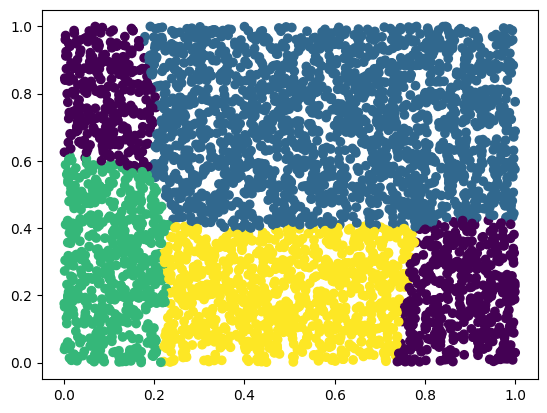

In [ ]:
plt.scatter(x_test_multi[:,0], x_test_multi[:,1], c = color)
plt.show()

___

# (Almost) Real task. (4 points)

This is alcohol classification task. You need to predict the target value.
Feel free to visualize and do whatever feels right to EDA and training model.
You can reuse previous models with slight changes or make a new one

#### **Сначала отделим признаки от таргета (X и y), которые после поделим на train, test и valid. Затем шкалируем с помощью StandartScaler наш набор данных, а к таргетным выборкам применяем OHE, как в предыдущих пунктах ДЗ (только в данном случае классов всего 3).**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

In [ ]:
data = load_wine(as_frame=True)
df = data.frame
df.head(n=20)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0,0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0


In [ ]:
X, y = data.data, data.target

y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_test_raw, X_valid_raw, y_test, y_valid = train_test_split(X_test_raw, y_test, train_size=0.7, shuffle=True)

In [ ]:
y_train_alcohe = np.reshape(F.one_hot(y_train.to(torch.int64), num_classes=3), (124,3))
y_test_alcohe = np.reshape(F.one_hot(y_test.to(torch.int64), num_classes=3), (37,3))
y_valid_alcohe = np.reshape(F.one_hot(y_valid.to(torch.int64), num_classes=3), (17,3))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
X_valid = scaler.transform(X_valid_raw)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)

####**Теперь зададим NN (Alcohol) и функцию для обучения (train_alc). NN я взяла из предыдущего пункта ДЗ и оставила один BatchNorm после первого линейного слоя, а у train_alc поменяла лишь метрику на macro_acc:**

In [ ]:
class Alcohol(nn.Module):
    def __init__(self, n_classes):
        super(Alcohol, self).__init__()
        self.layer1 = nn.Linear(13, 120)
        self.batch_norm1 = nn.BatchNorm1d(120)
        self.act1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(120, 30)
        self.act2 = nn.LeakyReLU()
        self.output = nn.Linear(30, n_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.act1(self.batch_norm1(self.layer1(x)))
        x = self.act2(self.layer2(x))
        x = self.softmax(self.output(x))
        return x

In [ ]:
def train_alc(model, loss_fn, opt,
          n_epochs, batch_size,
          X_train, y_train, X_val=None, y_val=None):

    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)
    x_val_ld = DataLoader(X_val, batch_size=1) if X_val is not None else None
    y_val_ld = DataLoader(y_val, batch_size=1) if y_val is not None else None
    batch_start = torch.arange(0, len(X_train), batch_size)
    # Hold the best model
    best_acc = - np.inf
    best_weights = None
    preds_history = []
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x, y in zip(x_train_loader, y_train_loader):
                #forward
                y_pred = model(x.float())
                loss = loss_fn(y_pred, y.float())
                # backward pass
                opt.zero_grad()
                loss.backward()
                # update weights
                opt.step()
                # print progress
                bar.set_postfix(mse=float(loss))
                # print progress
                acc = (y_pred.round() == y).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        preds_history.append(loss.item())
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.98:
            break

    # restore model and return best accuracy
    model.load_state_dict(best_weights)

    return best_acc, model, y_pred

#### **Обучение (оставляем те же оптимизатор и фукнцию потерь):**

In [ ]:
model_alcohol = Alcohol(n_classes=3)
loss = nn.CrossEntropyLoss()
optim_multi = optim.Adam(model_alcohol.parameters(), lr=1e-4)

acc, models, y_pred = train_alc(model_alcohol, loss, optim_multi, 50, 8, X_train, y_train_alcohe, X_valid, y_valid_alcohe)

Epoch 12:   0%|          | 0/16 [00:00<?, ?batch/s, acc=1, loss=0.818]


In [ ]:
print(acc)

0.9803921580314636


#### **Лосс всё равно остается достаточно большим, но точность хорошая. Проверим на тестовой выборке:**

In [ ]:
y_pred_new = models(X_test)
y_pred_new

tensor([[0.1350, 0.6530, 0.2119],
        [0.1479, 0.3389, 0.5132],
        [0.1834, 0.4034, 0.4132],
        [0.8984, 0.0659, 0.0357],
        [0.1380, 0.8141, 0.0479],
        [0.2294, 0.6923, 0.0783],
        [0.1613, 0.2986, 0.5401],
        [0.1381, 0.3743, 0.4876],
        [0.7114, 0.1819, 0.1067],
        [0.6532, 0.2141, 0.1327],
        [0.1467, 0.7124, 0.1409],
        [0.4677, 0.4051, 0.1272],
        [0.2748, 0.5258, 0.1994],
        [0.6047, 0.2826, 0.1127],
        [0.1622, 0.2876, 0.5502],
        [0.1580, 0.5514, 0.2906],
        [0.1498, 0.3787, 0.4716],
        [0.6430, 0.2244, 0.1326],
        [0.1310, 0.6558, 0.2132],
        [0.2302, 0.5084, 0.2613],
        [0.1783, 0.6591, 0.1626],
        [0.1554, 0.2419, 0.6028],
        [0.7853, 0.1438, 0.0709],
        [0.7074, 0.1855, 0.1071],
        [0.3733, 0.5038, 0.1230],
        [0.4916, 0.3218, 0.1866],
        [0.1623, 0.6575, 0.1802],
        [0.4805, 0.3388, 0.1807],
        [0.2080, 0.6051, 0.1870],
        [0.304

In [ ]:
predicted = torch.argmax(y_pred_new, axis=1)
predicted_new = np.reshape(F.one_hot(predicted.to(torch.int64), num_classes=3), (37,3))

In [ ]:
best_acc_alcohol = 0
acc_alcohol = (predicted_new.round() == y_test_alcohe).float().mean()
acc_alcohol = float(acc_alcohol)
if acc_alcohol > best_acc_alcohol:
   best_acc_alcohol = acc_alcohol

In [ ]:
print(f'Accuracy on test set: {best_acc_alcohol}')

Accuracy on test set: 0.9819819927215576
